## SARIMAX_base_HAC rivisto con Pulse Dummy

Dall'analisi di SARIMAX_base_HAC si è notato che i parametri della componente ARMA hanno un’elevata significatività statistica, ma il coefficiente della shift dummy per marzo 2022 risulta **non statisticamente significativo**. Questo fa pensare che una dummy di livello non cattura adeguatamente l'impatto dell'evento sulla serie temporale dell'inflazione, perché in presenza di eteroschedasticità può risultare instabile sotto stima robusta.

Per questo motivo, si è pensato di indagare se lo shock di marzo 2022 fosse transitorio, piuttosto che strutturale e permanente. Per testare ciò, una **pulse dummy**, dalla durata variabile (e configurabile) potrebbe essere più appropriata se l'effetto è temporaneo, perché è più conservativa e può risultare più stabile numericamente.

>>> INIZIO SCRIPT: Costruzione Modello Base SARIMAX con Pulse Dummy <<<

I risultati di questo script verranno salvati in: '/Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/modello_base_pulse_dummy_v1'

--- Caricamento Serie Stazionarie da: /Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2/indici_gt_nic_stazionari_fase2.csv ---
Serie caricate con successo. Shape: (252, 3)
Serie inflazione caricata: 251 osservazioni da 2004-02 a 2024-12

--- Creazione Pulse Dummy (Breakpoint: 2022-03-01, Durata: 1 mesi) ---
Creata dummy di IMPULSO: dummy_pulse1m_2022_03_pulse
  -> Valore 1 da 2022-03-01 a 2022-03-01 (1 mesi)
Pulse dummy creata: 1.0 mesi con valore 1 su 251 totali

--- Analisi ACF/PACF per: NIC_destag_ISTAT_diff1 (guida visuale per identificazione ordini) ---
Grafico ACF/PACF salvato in: /Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/modello_base_pulse_dummy_v1/acf_pacf_inflazione_staz_pulse.png


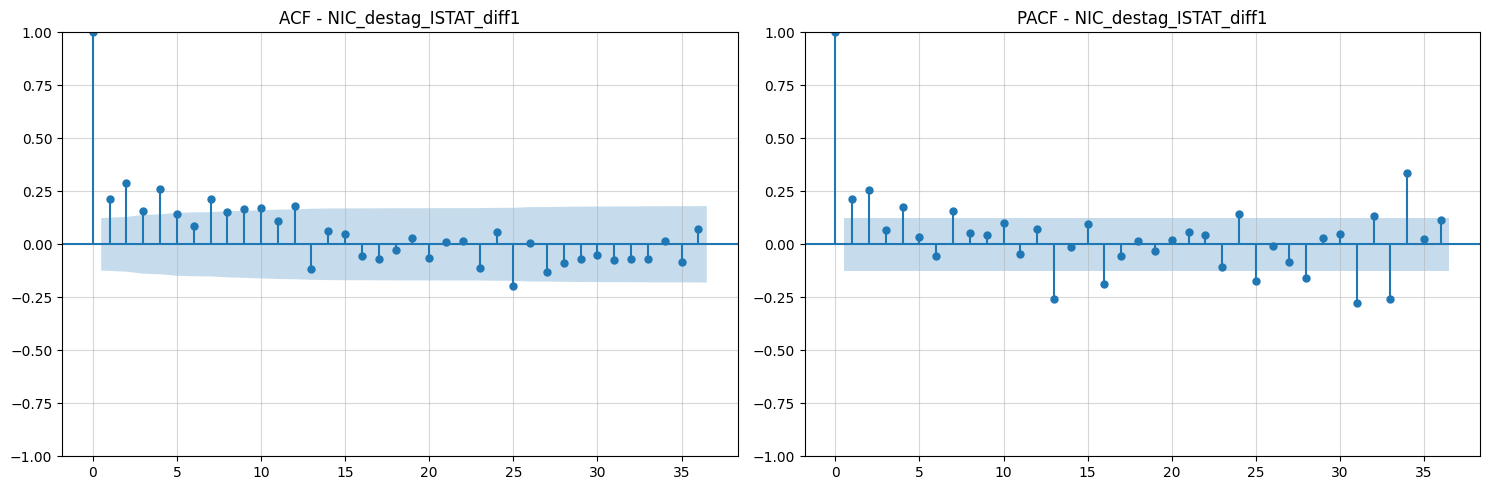


--- Inizio Grid Search con Pulse Dummy ---

=== INIZIO RICERCA AUTOMATICA ORDINI SARIMA (Criterio: AIC) ===
Range ordini: p<=2, q<=2, P<=1, Q<=1 | d=0, D=0, s=12
Numero totale di combinazioni da testare: 36
Sto testando il modello 1/36: SARIMA(0, 0, 0)(0, 0, 0, 12)...
Sto testando il modello 11/36: SARIMA(0, 0, 2)(1, 0, 0, 12)...
Sto testando il modello 21/36: SARIMA(1, 0, 2)(0, 0, 0, 12)...
Sto testando il modello 31/36: SARIMA(2, 0, 1)(1, 0, 0, 12)...
Sto testando il modello 36/36: SARIMA(2, 0, 2)(1, 0, 1, 12)...

36 modelli sono convergiti con successo su 36 testati.

=== MIGLIOR MODELLO TROVATO (secondo AIC e Ljung-Box) ===
Ordini: SARIMA(1, 0, 1)(0, 0, 0, 12)
AIC: 221.461, BIC: 235.563, LogLik: -106.731
Ljung-Box p-value (residui): 0.348
  -> OK: Residui sembrano non autocorrelati.
=== FINE RICERCA AUTOMATICA ORDINI SARIMA ===

Risultati grid search salvati in: /Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/modello_base_pulse_dummy_v1/grid_search_sarimax_results_pulse_du

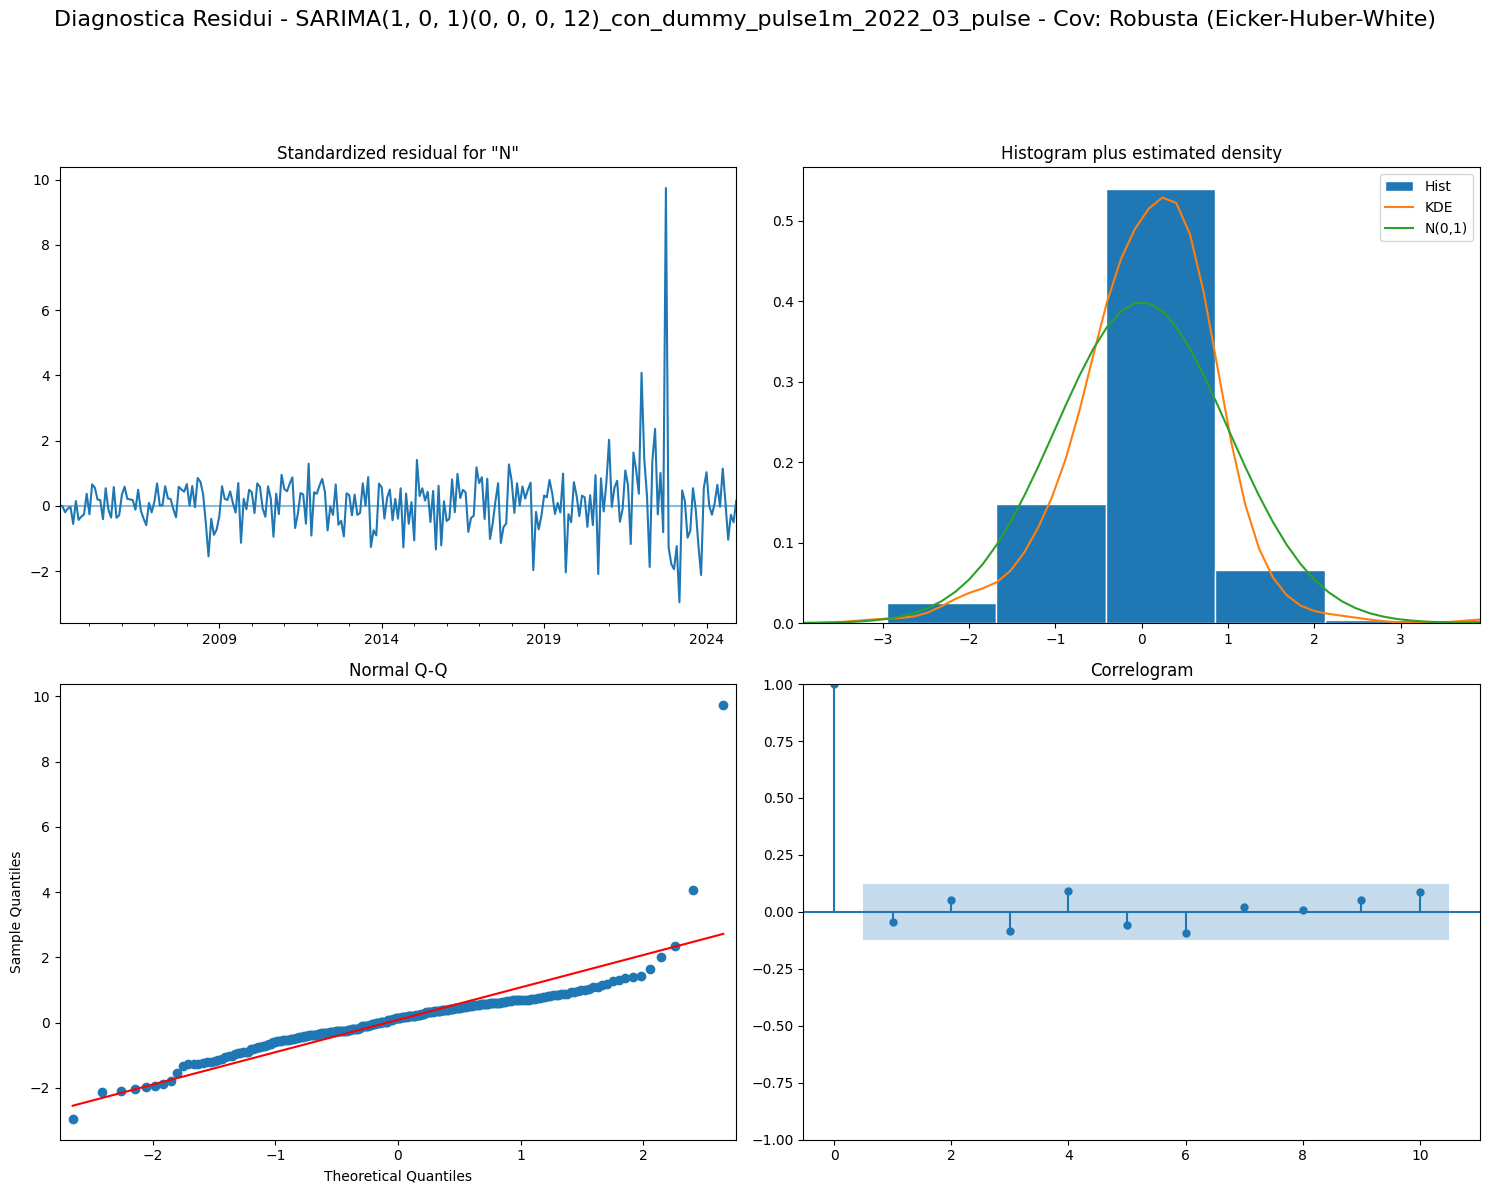


--- Test Statistici sui Residui ---
Test di Ljung-Box (lag=10): p-value = 0.3476 (H0: no autocorrelazione)
  -> OK: Residui probabilmente non autocorrelati.
Test di Jarque-Bera (normalità): p-value = 0.0000 (H0: normalità)
  -> ATTENZIONE: Residui potrebbero non essere normali.
--- Fine Diagnostica ---
✓ Miglior modello SARIMAX salvato in: /Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/modello_base_pulse_dummy_v1/miglior_modello_sarimax_pulse_dummy_pulse1m_2022_03_pulse_robusta.pkl
  Tipo covarianza: Robusta (Eicker-Huber-White)
  Dummy utilizzata: dummy_pulse1m_2022_03_pulse

>>> SCRIPT MODELLO BASE CON PULSE DUMMY COMPLETATO <<<
Tutti i file di output sono stati salvati in: /Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/modello_base_pulse_dummy_v1


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import pickle

# Ignoro i warning di convergenza e altri, per output più pulito
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- CONFIGURAZIONE GENERALE ---
PATH_INPUT_DIR_FASE2 = "/Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2"
FILE_SERIE_STAZIONARIE_IN = os.path.join(PATH_INPUT_DIR_FASE2, "indici_gt_nic_stazionari_fase2.csv")
PATH_OUTPUT_MODELLI = "/Users/tommaso/Desktop/tesi-inflation-gt/SARIMAX_modelli"
PATH_OUTPUT_MODELLO_BASE = os.path.join(PATH_OUTPUT_MODELLI, "modello_base_pulse_dummy_v1") 

FILE_GRAFICO_ACFPACF_INFL = os.path.join(PATH_OUTPUT_MODELLO_BASE, "acf_pacf_inflazione_staz_pulse.png")
FILE_RISULTATI_GRID_SEARCH = os.path.join(PATH_OUTPUT_MODELLO_BASE, "grid_search_sarimax_results_pulse.csv")
FILE_GRAFICO_DIAGNOSTICA_BEST = os.path.join(PATH_OUTPUT_MODELLO_BASE, "diagnostica_miglior_modello_pulse.png") 
FILE_MODELLO_PICKLE = os.path.join(PATH_OUTPUT_MODELLO_BASE, "miglior_modello_sarimax_pulse.pkl")

COL_INFLAZIONE_STAZ = 'NIC_destag_ISTAT_diff1'
BREAKPOINT_DATE_DUMMY = '2022-03-01'
DURATA_IMPULSO_MESI = 1  # Durata della pulse dummy (parametro configurabile)
MAX_LAGS_ACF_PACF = 36
SEASONAL_PERIOD = 12
MAX_P_NON_STAG, MAX_Q_NON_STAG = 2, 2
MAX_P_STAG, MAX_Q_STAG = 1, 1
ORDER_d_NON_STAG, ORDER_D_STAG = 0, 0
CRITERION_SELEZIONE = 'aic'

# --- FUNZIONI AUSILIARIE ---
def carica_dati_stazionari(path_file):
    """Carico le serie stazionarie dal file CSV specificato"""
    print(f"--- Caricamento Serie Stazionarie da: {path_file} ---")
    try:
        df = pd.read_csv(path_file, index_col=0)
        df.index = pd.to_datetime(df.index)
        print(f"Serie caricate con successo. Shape: {df.shape}")
        return df
    except Exception as e: 
        print(f"ERRORE caricamento: {e}")
        return None

def crea_dummy_intervento_specifica(serie_index, breakpoint_date_str, dummy_type="level", pulse_duration_months=1, dummy_name_prefix="dummy"):
    """
    Creo una variabile dummy di intervento con opzioni multiple.
    
    Parametri:
    - serie_index: indice temporale della serie
    - breakpoint_date_str: data di inizio dell'intervento (formato 'YYYY-MM-DD')
    - dummy_type: "level" (0 prima, 1 dopo) o "pulse" (1 per durata specificata, 0 altrove)
    - pulse_duration_months: durata dell'impulso in mesi (usato solo se dummy_type="pulse")
    - dummy_name_prefix: prefisso per il nome della dummy
    
    Restituisce: pd.Series con la dummy creata
    """
    breakpoint_ts = pd.Timestamp(breakpoint_date_str)
    dummy_name = f"{dummy_name_prefix}_{breakpoint_date_str.split('-')[0]}_{breakpoint_date_str.split('-')[1]}_{dummy_type}"
    
    if dummy_type == "level":
        # Creo una shift dummy: 0 prima del breakpoint, 1 dopo
        dummy = pd.Series(0, index=serie_index, name=dummy_name)
        dummy[serie_index >= breakpoint_ts] = 1
        print(f"Creata dummy di LEVEL SHIFT: {dummy_name}")
        print(f"  -> Valore 1 da {breakpoint_ts.strftime('%Y-%m-%d')} in poi")
        
    elif dummy_type == "pulse":
        # Creo una pulse dummy: 1 per la durata specificata, 0 altrove
        dummy = pd.Series(0, index=serie_index, name=dummy_name)
        
        # Calcolo la data di fine dell'impulso
        start_pulse = breakpoint_ts
        end_pulse = start_pulse + pd.DateOffset(months=pulse_duration_months - 1)  # -1 perché includo il mese di inizio
        
        # Identifico le date che rientrano nel periodo dell'impulso
        pulse_period_index = serie_index[(serie_index >= start_pulse) & (serie_index <= end_pulse)]
        
        if not pulse_period_index.empty:
            dummy[pulse_period_index] = 1
            print(f"Creata dummy di IMPULSO: {dummy_name}")
            print(f"  -> Valore 1 da {start_pulse.strftime('%Y-%m-%d')} a {end_pulse.strftime('%Y-%m-%d')} ({len(pulse_period_index)} mesi)")
        else:
            print(f"ATTENZIONE: Nessuna data trovata per l'impulso specificato per {dummy_name}. La dummy sarà tutta zero.")
    else:
        raise ValueError("Tipo di dummy non valido. Scegliere 'level' o 'pulse'.")
    
    return dummy

def auto_sarima_grid_search(y_series, exog_series=None,
                           max_p=2, max_q=2, max_P=1, max_Q=1,
                           d=0, D=0, s=12,
                           criterion='aic', verbose=True):
    """Eseguo una grid search per trovare i migliori ordini SARIMA"""
    print(f"\n=== INIZIO RICERCA AUTOMATICA ORDINI SARIMA (Criterio: {criterion.upper()}) ===")
    print(f"Range ordini: p<={max_p}, q<={max_q}, P<={max_P}, Q<={max_Q} | d={d}, D={D}, s={s}")
    
    # Genero tutte le combinazioni possibili degli ordini
    p_rng, q_rng, P_rng, Q_rng = range(max_p+1), range(max_q+1), range(max_P+1), range(max_Q+1)
    all_orders_combinations = list(itertools.product(p_rng, q_rng, P_rng, Q_rng))
    print(f"Numero totale di combinazioni da testare: {len(all_orders_combinations)}")
    
    results_list = []
    
    for i, (p_val, q_val, P_val, Q_val) in enumerate(all_orders_combinations):
        current_order = (p_val, d, q_val)
        current_seasonal_order = (P_val, D, Q_val, s)
        
        if verbose and (i % 10 == 0 or i == len(all_orders_combinations) - 1):
            print(f"Sto testando il modello {i+1}/{len(all_orders_combinations)}: SARIMA{current_order}{current_seasonal_order}...")
        
        try:
            # Definisco e stimo il modello SARIMAX
            model = sm.tsa.SARIMAX(y_series, exog=exog_series, 
                                 order=current_order, seasonal_order=current_seasonal_order,
                                 enforce_stationarity=False, enforce_invertibility=False,
                                 initialization='approximate_diffuse')
            fitted_model = model.fit(disp=False, maxiter=200, method='lbfgs')
            
            # Estraggo il criterio di selezione
            current_criterion_val = getattr(fitted_model, criterion.lower())
            
            # Eseguo il test di Ljung-Box sui residui
            lb_lags_to_test = min(10, len(y_series)//5) if len(y_series)//5 > 0 else 1
            lb_pvalue = np.nan
            if lb_lags_to_test > 0:
                 lb_df = acorr_ljungbox(fitted_model.resid, lags=[lb_lags_to_test], return_df=True)
                 lb_pvalue = lb_df['lb_pvalue'].iloc[0] if not lb_df.empty and 'lb_pvalue' in lb_df.columns else np.nan
            
            # Salvo i risultati
            results_list.append({
                'order': current_order, 
                'seasonal_order': current_seasonal_order,
                'AIC': fitted_model.aic, 
                'BIC': fitted_model.bic,
                'LogLikelihood': fitted_model.llf, 
                'LjungBox_pvalue': lb_pvalue,
                'Converged': fitted_model.mle_retvals.get('converged', False)
            })
            
        except Exception as e:
            # In caso di errore, salvo comunque il tentativo
            results_list.append({
                'order': current_order, 
                'seasonal_order': current_seasonal_order,
                'AIC': np.nan, 
                'BIC': np.nan, 
                'LogLikelihood': np.nan,
                'LjungBox_pvalue': np.nan, 
                'Converged': False, 
                'Error': str(e)[:50]
            })
    
    # Analizzo i risultati
    results_df = pd.DataFrame(results_list)
    valid_results_df = results_df[results_df['Converged'] == True].copy()
    
    if valid_results_df.empty:
        print("ERRORE: Nessun modello SARIMAX è convergito durante la grid search.")
        return None, None, float('inf'), results_df
    
    print(f"\n{len(valid_results_df)} modelli sono convergiti con successo su {len(results_df)} testati.")
    
    # Ordino per criterio di selezione e p-value di Ljung-Box
    valid_results_df = valid_results_df.sort_values(by=[criterion.upper(), 'LjungBox_pvalue'], ascending=[True, False])
    best_model_row = valid_results_df.iloc[0]
    
    final_best_order = best_model_row['order']
    final_best_seasonal_order = best_model_row['seasonal_order']
    final_best_criterion_val = best_model_row[criterion.upper()]
    
    print(f"\n=== MIGLIOR MODELLO TROVATO (secondo {criterion.upper()} e Ljung-Box) ===")
    print(f"Ordini: SARIMA{final_best_order}{final_best_seasonal_order}")
    print(f"{criterion.upper()}: {final_best_criterion_val:.3f}, BIC: {best_model_row['BIC']:.3f}, LogLik: {best_model_row['LogLikelihood']:.3f}")
    print(f"Ljung-Box p-value (residui): {best_model_row['LjungBox_pvalue']:.3f}")
    
    if best_model_row['LjungBox_pvalue'] > 0.05:
        print("  -> OK: Residui sembrano non autocorrelati.")
    else:
        print("  -> ATTENZIONE: Residui potrebbero essere autocorrelati.")
    
    print("=== FINE RICERCA AUTOMATICA ORDINI SARIMA ===\n")
    
    return final_best_order, final_best_seasonal_order, final_best_criterion_val, results_df

def plot_model_diagnostics_final(fitted_model_results, model_name="Modello", path_output_grafici=None, save_filename="diagnostica_modello.png"):
    """Eseguo la diagnostica grafica e i test statistici sui residui del modello"""
    print(f"\n--- Diagnostica Grafica e Test Residui per: {model_name} ---")
    residuals = fitted_model_results.resid
    
    try:
        # Uso la funzione integrata di statsmodels per i grafici diagnostici
        fig = fitted_model_results.plot_diagnostics(figsize=(15, 12))
        fig.suptitle(f"Diagnostica Residui - {model_name}", fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Salvo il grafico se specificato un percorso
        if path_output_grafici:
            if not os.path.exists(path_output_grafici): 
                os.makedirs(path_output_grafici)
            full_save_path = os.path.join(path_output_grafici, save_filename)
            plt.savefig(full_save_path)
            print(f"Grafico diagnostica salvato in: {full_save_path}")
        
        plt.show()
        
    except Exception as e:
        print(f"ERRORE durante fitted_model.plot_diagnostics(): {e}")
        print("I grafici diagnostici automatici non sono disponibili, ma continuo con i test statistici.")

    # Eseguo i test statistici sui residui
    print("\n--- Test Statistici sui Residui ---")
    
    # Test di Ljung-Box per autocorrelazione
    lb_lags_diag = min(10, len(residuals)//5) if len(residuals)//5 > 0 else 1
    if lb_lags_diag > 0:
        lb_df_diag = acorr_ljungbox(residuals, lags=[lb_lags_diag], return_df=True)
        lb_pvalue_diag = lb_df_diag['lb_pvalue'].iloc[0] if not lb_df_diag.empty else np.nan
        print(f"Test di Ljung-Box (lag={lb_lags_diag}): p-value = {lb_pvalue_diag:.4f} (H0: no autocorrelazione)")
        if lb_pvalue_diag > 0.05:
            print("  -> OK: Residui probabilmente non autocorrelati.")
        else:
            print("  -> ATTENZIONE: Residui potrebbero essere autocorrelati.")
    else:
        print("Test Ljung-Box non eseguito (serie residui troppo corta).")
    
    # Test di Jarque-Bera per normalità
    if len(residuals) > 2:
        jb_stat, jb_pvalue = jarque_bera(residuals)
        print(f"Test di Jarque-Bera (normalità): p-value = {jb_pvalue:.4f} (H0: normalità)")
        if jb_pvalue > 0.05:
            print("  -> OK: Residui probabilmente normali.")
        else:
            print("  -> ATTENZIONE: Residui potrebbero non essere normali.")
    else:
        print("Test Jarque-Bera non eseguito (serie residui troppo corta).")
    
    print("--- Fine Diagnostica ---")

# --- ESECUZIONE SCRIPT PRINCIPALE ---
if __name__ == "__main__":
    print(">>> INIZIO SCRIPT: Costruzione Modello Base SARIMAX con Pulse Dummy <<<\n")
    
    # Creo la directory di output se non esiste
    os.makedirs(PATH_OUTPUT_MODELLO_BASE, exist_ok=True)
    print(f"I risultati di questo script verranno salvati in: '{PATH_OUTPUT_MODELLO_BASE}'\n")

    # Carico i dati delle serie stazionarie
    df_serie_stazionarie = carica_dati_stazionari(FILE_SERIE_STAZIONARIE_IN)
    if df_serie_stazionarie is None or COL_INFLAZIONE_STAZ not in df_serie_stazionarie.columns:
        print(f"ERRORE CRITICO: Dati non caricati o colonna '{COL_INFLAZIONE_STAZ}' mancante.")
        exit()

    # Estraggo la serie dell'inflazione stazionaria
    y_inflazione = df_serie_stazionarie[COL_INFLAZIONE_STAZ].dropna()
    if y_inflazione.empty:
        print(f"ERRORE: Serie inflazione '{COL_INFLAZIONE_STAZ}' vuota.")
        exit()

    print(f"Serie inflazione caricata: {len(y_inflazione)} osservazioni da {y_inflazione.index.min().strftime('%Y-%m')} a {y_inflazione.index.max().strftime('%Y-%m')}")

    # --- CREAZIONE DELLA PULSE DUMMY ---
    print(f"\n--- Creazione Pulse Dummy (Breakpoint: {BREAKPOINT_DATE_DUMMY}, Durata: {DURATA_IMPULSO_MESI} mesi) ---")
    dummy_intervento = crea_dummy_intervento_specifica(
        y_inflazione.index, 
        BREAKPOINT_DATE_DUMMY, 
        dummy_type="pulse", 
        pulse_duration_months=DURATA_IMPULSO_MESI,
        dummy_name_prefix=f"dummy_pulse{DURATA_IMPULSO_MESI}m"
    )
    
    # Allineo la dummy con l'indice della serie inflazione
    dummy_intervento_aligned = dummy_intervento.reindex(y_inflazione.index, fill_value=0).astype(float)
    
    print(f"Pulse dummy creata: {dummy_intervento_aligned.sum()} mesi con valore 1 su {len(dummy_intervento_aligned)} totali")

    # --- ANALISI ACF/PACF PRELIMINARE ---
    print(f"\n--- Analisi ACF/PACF per: {COL_INFLAZIONE_STAZ} (guida visuale per identificazione ordini) ---")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    plot_acf(y_inflazione, lags=MAX_LAGS_ACF_PACF, ax=axes[0], title=f"ACF - {COL_INFLAZIONE_STAZ}")
    axes[0].grid(True, alpha=0.5)
    
    plot_pacf(y_inflazione, lags=MAX_LAGS_ACF_PACF, ax=axes[1], title=f"PACF - {COL_INFLAZIONE_STAZ}", method='ols')
    axes[1].grid(True, alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(FILE_GRAFICO_ACFPACF_INFL)
    print(f"Grafico ACF/PACF salvato in: {FILE_GRAFICO_ACFPACF_INFL}")
    plt.show()

    # --- GRID SEARCH PER IDENTIFICAZIONE ORDINI OTTIMALI ---
    print(f"\n--- Inizio Grid Search con Pulse Dummy ---")
    best_order, best_seasonal_order, _, all_search_results_df = auto_sarima_grid_search(
        y_inflazione,
        exog_series=dummy_intervento_aligned,  # Uso la pulse dummy come variabile esogena
        max_p=MAX_P_NON_STAG, max_q=MAX_Q_NON_STAG, 
        max_P=MAX_P_STAG, max_Q=MAX_Q_STAG,
        d=ORDER_d_NON_STAG, D=ORDER_D_STAG, 
        s=SEASONAL_PERIOD, 
        criterion=CRITERION_SELEZIONE
    )

    # Salvo i risultati della grid search
    if all_search_results_df is not None:
        grid_search_filename = FILE_RISULTATI_GRID_SEARCH.replace(".csv", f"_{dummy_intervento_aligned.name}.csv")
        all_search_results_df.to_csv(grid_search_filename, index=False)
        print(f"Risultati grid search salvati in: {grid_search_filename}")

    # --- STIMA FINALE DEL MIGLIOR MODELLO ---
    if best_order and best_seasonal_order:
        model_label_base = f"SARIMA{best_order}{best_seasonal_order}_con_{dummy_intervento_aligned.name}"
        print(f"\n--- Stima Finale e Diagnostica del Miglior Modello: {model_label_base} ---")
        
        # Definisco il modello con gli ordini migliori trovati
        miglior_modello_def = sm.tsa.SARIMAX(
            y_inflazione,
            exog=dummy_intervento_aligned,
            order=best_order,
            seasonal_order=best_seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
            initialization='approximate_diffuse'
        )
        
        risultati_miglior_modello = None
        tipo_covarianza_usata = "Non Robusta (Default)"

        # Tento la stima con diversi tipi di errori standard (strategia di fallback)
        print(f"Sto tentando la stima del modello con errori standard HAC (Newey-West)...")
        try:
            risultati_miglior_modello = miglior_modello_def.fit(
                disp=False, maxiter=250,
                cov_type='HAC',
                cov_kwds={
                    'kernel': 'bartlett',       # Kernel di Bartlett per Newey-West
                    'use_correction': True      # Correzione per campioni finiti
                    # Lascio maxlags al default di statsmodels per stabilità numerica
                }
            )
            tipo_covarianza_usata = "HAC (Newey-West)"
            print("✓ Stima con errori HAC completata con successo.")
            
        except Exception as e_hac:
            print(f"✗ ERRORE durante stima HAC: {e_hac}")
            print("Tento la stima con errori standard robusti semplici (HC0)...")
            
            try:
                risultati_miglior_modello = miglior_modello_def.fit(
                    disp=False, maxiter=250,
                    cov_type='robust'  # Errori standard robusti di Eicker-Huber-White
                )
                tipo_covarianza_usata = "Robusta (Eicker-Huber-White)"
                print("✓ Stima con errori 'robust' completata con successo.")
                
            except Exception as e_robust:
                print(f"✗ ERRORE durante stima 'robust': {e_robust}")
                print("Tento la stima con errori standard non robusti (default)...")
                
                try:
                    risultati_miglior_modello = miglior_modello_def.fit(disp=False, maxiter=250)
                    tipo_covarianza_usata = "Non Robusta (Default OIM/OPG)"
                    print("✓ Stima con errori standard default completata con successo.")
                    print("⚠️  ATTENZIONE: L'inferenza potrebbe essere meno affidabile in presenza di eteroschedasticità.")
                    
                except Exception as e_default:
                    print(f"✗ ERRORE CRITICO: Impossibile stimare il modello: {e_default}")
                    risultati_miglior_modello = None
        
        # Procedo con diagnostica e salvataggio solo se la stima è riuscita
        if risultati_miglior_modello:
            model_final_name_suffix = f"{dummy_intervento_aligned.name}_{tipo_covarianza_usata.split(' ')[0].lower()}"
            model_final_display_name = f"{model_label_base} - Cov: {tipo_covarianza_usata}"
            
            print(f"\n--- Sommario Miglior Modello ({tipo_covarianza_usata}) ---")
            print(risultati_miglior_modello.summary())
            
            # Verifico la significatività della pulse dummy
            if len(risultati_miglior_modello.params) > len(best_order):  # Se ci sono variabili esogene
                dummy_coeff = risultati_miglior_modello.params.iloc[-1]  # Ultimo parametro dovrebbe essere la dummy
                dummy_pvalue = risultati_miglior_modello.pvalues.iloc[-1]
                print(f"\n--- Risultati Pulse Dummy ---")
                print(f"Coefficiente pulse dummy: {dummy_coeff:.4f}")
                print(f"P-value pulse dummy: {dummy_pvalue:.4f}")
                if dummy_pvalue < 0.05:
                    print("✓ La pulse dummy è statisticamente significativa al 5%")
                else:
                    print("✗ La pulse dummy NON è statisticamente significativa al 5%")

            # Eseguo la diagnostica completa
            plot_model_diagnostics_final(
                risultati_miglior_modello,
                model_name=model_final_display_name,
                path_output_grafici=PATH_OUTPUT_MODELLO_BASE,
                save_filename=f"diagnostica_{model_final_name_suffix}.png"
            )
            
            # Salvo il modello stimato
            model_pickle_filename = FILE_MODELLO_PICKLE.replace(".pkl", f"_{model_final_name_suffix}.pkl")
            with open(model_pickle_filename, 'wb') as pkl_file:
                pickle.dump(risultati_miglior_modello, pkl_file)
            print(f"✓ Miglior modello SARIMAX salvato in: {model_pickle_filename}")
            print(f"  Tipo covarianza: {tipo_covarianza_usata}")
            print(f"  Dummy utilizzata: {dummy_intervento_aligned.name}")
            
        else:
            print("✗ La stima del modello finale è fallita con tutti i tipi di covarianza tentati.")

    else:
        print("\n✗ Nessun modello ottimale trovato dalla grid search. Impossibile procedere con la stima finale.")

    print(f"\n>>> SCRIPT MODELLO BASE CON PULSE DUMMY COMPLETATO <<<")
    print(f"Tutti i file di output sono stati salvati in: {PATH_OUTPUT_MODELLO_BASE}")
